In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import itertools
from itertools import count

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statannot import add_stat_annotation

import seaborn as sns
import pylab as plt

from importlib import reload

import sys
import residuals
sys.path.insert(1,'../../make_figures/')
import plots

In [2]:
data_path = '/scratch/c.c21013066/data/ukbiobank/'
model_path = '/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/hc_residuals/noOsteo'
sample_path = '/scratch/c.c21013066/data/ukbiobank/sample/withGP/noOsteo'
image_path = plots.set_dir()

In [5]:
target = 'No_wear_time_bias_adjusted_average_acceleration'
covariates = ['accelerometry_age','male','BMI']
res_name = "average acceleration residual_bmi"
drop_healthy = 'nonHC'

In [6]:
# get data for which we want residuals
acc = pd.read_csv(f'{data_path}phenotypes/accelerometer/unmatched_all_HCnoOsteo.csv',index_col=0)
subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']
merged_ = []
for name in subset:
    life = pd.read_csv(f'{data_path}sample/withGP/noOsteo/{name}_controlNo{drop_healthy}_risk.csv').set_index('eid')
    blood = pd.read_csv(f'{data_path}sample/withGP/noOsteo/{name}_controlNo{drop_healthy}_blood.csv').set_index('eid')
    merged = pd.merge(life,blood,right_index=True,left_index=True,how='outer',suffixes=['','_blood'])
    merged = merged.drop(columns=merged.filter(regex='_blood').columns)
    acc_diag = acc[acc['diagnosis']==name]
    merged = pd.merge(acc_diag,merged,right_index=True,left_index=True,how='left',suffixes=['_life',''])
    merged = merged.drop(columns=merged.filter(regex='_life').columns)
    merged_.append(merged)
merged_ = pd.concat(merged_)
print(merged_['diagnosis'].value_counts())
merged_ = merged_.dropna(subset=covariates)
print(merged_['diagnosis'].value_counts())

Osteoarthritis          13407
Depression               9586
AllCauseDementia         1369
AllCauseParkinsonism      519
ParkinsonDisease          469
AlzheimerDisease          212
Dystonia                   81
Name: diagnosis, dtype: int64
Osteoarthritis          11556
Depression               8170
AllCauseDementia         1181
AllCauseParkinsonism      443
ParkinsonDisease          397
AlzheimerDisease          175
Dystonia                   66
Name: diagnosis, dtype: int64


In [8]:
# get data for which we want residuals
acc = pd.read_csv(f'{data_path}phenotypes/accelerometer/unmatched_all_HCnoOsteo_NoDepressedNoPD.csv',index_col=0)
subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']
merged_n = []
for name in subset:
    life = pd.read_csv(f'{sample_path}/{name}_controlNo{drop_healthy}_risk.csv').set_index('eid')
    blood = pd.read_csv(f'{sample_path}/{name}_controlNo{drop_healthy}_blood.csv').set_index('eid')
    merged = pd.merge(life,blood,right_index=True,left_index=True,how='outer',suffixes=['','_blood'])
    merged = merged.drop(columns=merged.filter(regex='_blood').columns)
    acc_diag = acc[acc['diagnosis']==name]
    merged = pd.merge(acc_diag,merged,right_index=True,left_index=True,how='left',suffixes=['_life',''])
    merged = merged.drop(columns=merged.filter(regex='_life').columns)
    merged_n.append(merged)
merged_n = pd.concat(merged_n)
print(merged_n['diagnosis'].value_counts())
merged_n = merged_n.dropna(subset=covariates)
print(merged_n['diagnosis'].value_counts())

Osteoarthritis          11380
Depression               9513
AllCauseDementia          452
ParkinsonDisease          396
AlzheimerDisease          165
Dystonia                   58
AllCauseParkinsonism       35
Name: diagnosis, dtype: int64
Osteoarthritis          9792
Depression              8102
AllCauseDementia         376
ParkinsonDisease         329
AlzheimerDisease         137
Dystonia                  45
AllCauseParkinsonism      34
Name: diagnosis, dtype: int64


# Adjust average acceleration

In [13]:
# get hc
hc = residuals.load_hc(path='/scratch/c.c21013066/data/ukbiobank/sample/withGP/noOsteo',disease='ParkinsonDisease',drop_healthy=drop_healthy,df_names=['risk','acc_QC'])
hc_clean = residuals.clean_hc(hc,covariates,target)

In [18]:
#get residuals
model,dfs_res = residuals.fit_get_res(hc_clean,merged_,target=target,covariates=covariates,res_name=res_name,intercept=True,
                                      save='/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/hc_residuals/noOsteo')
hc_res = residuals.get_residuals(model,hc_clean,res_name=res_name,covariates=covariates,target=target,intercept=True)
dfs_res_n = residuals.get_residuals(model,merged_n,res_name=res_name,covariates=covariates,target=target,intercept=True)

                                           OLS Regression Results                                          
Dep. Variable:     No_wear_time_bias_adjusted_average_acceleration   R-squared:                       0.041
Model:                                                         OLS   Adj. R-squared:                  0.041
Method:                                              Least Squares   F-statistic:                     508.5
Date:                                             Thu, 23 Feb 2023   Prob (F-statistic):          9.88e-324
Time:                                                     01:08:51   Log-Likelihood:            -1.4838e+05
No. Observations:                                            36058   AIC:                         2.968e+05
Df Residuals:                                                36054   BIC:                         2.968e+05
Df Model:                                                        3                                         
Covariance Type:            

/scratch/c.c21013066/Paper/ProdromalUKBB/analyses/2_residuals/residuals.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred'] = 0
/scratch/c.c21013066/Paper/ProdromalUKBB/analyses/2_residuals/residuals.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred'] += params[cov] * data[cov]
/scratch/c.c21013066/Paper/ProdromalUKBB/analyses/2_residuals/residuals.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [19]:
# save
hc_res.to_csv(f'{data_path}/phenotypes/accelerometer/HCnoOsteo_residuals_bmi_intercept.csv')
dfs_res.to_csv(f'{data_path}/phenotypes/accelerometer/unmatched_all_residual_BMI_HCnoOsteo_intercept.csv')
dfs_res_n.to_csv(f'{data_path}/phenotypes/accelerometer/unmatched_all_NoDepressedNoPD_residual_BMI_HCnoOsteo_intercept.csv')

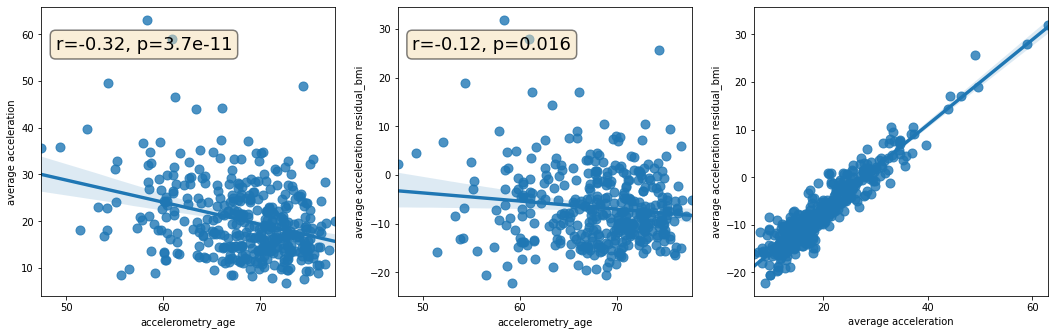

In [20]:
def annotate(x,y, ax):
    r, p = stats.pearsonr(x, y)
    ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
data = dfs_res[dfs_res['diagnosis']=='ParkinsonDisease']
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
plots.plot_context()
ax1 = sns.regplot(y=target,x="accelerometry_age",data=data,ax=axes[0])
ax1.set_ylabel('average acceleration')
annotate(data['accelerometry_age'],data[target],ax1)
ax2 = sns.regplot(y=res_name,x="accelerometry_age",data=data,ax=axes[1])
annotate(data['accelerometry_age'],data[res_name],ax2)
ax3 = sns.regplot(x=target,y=res_name,data=data,ax=axes[2])
ax3.set_xlabel('average acceleration')
plt.tight_layout()
#plt.savefig(f'{image_path}/age_effect_correction.png',bbox_inches='tight')

# Adjust derived sleep phenotypes

In [ ]:
# get residuals for sleep phenotypes for only matched samples
targets = ['mean_sleep_hours_per24h','std_movement_during_sleep','mean_max_sleep_hours_consecutive_per24h','mean_N_sleep_intervals_22-10','mean_N_sleep_intervals_10-22',
          'mean_N_sleep_intervals_07-23','mean_N_sleep_intervals_23-07','mean_movement_during_light']
covariates = ['accelerometry_age','male','BMI']
# get and clean hc
hc = merged_[merged_['Status']=='Healthy']
hc = hc.dropna(subset=np.hstack([targets,covariates]),how='all')
hc = hc[~hc.index.duplicated(keep='first')]
hc = hc.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                       'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})

# clean dfs
merged_clean = merged_.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                                      'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})
merged_n_clean = merged_n.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                                         'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})

In [9]:
# get residuals for sleep phenotypes for all HC
targets = ['Overallaverage','mean_sleep_hours_per24h','std_movement_during_sleep','mean_max_sleep_hours_consecutive_per24h','mean_N_sleep_intervals_22-10','mean_N_sleep_intervals_10-22',
          'mean_N_sleep_intervals_07-23','mean_N_sleep_intervals_23-07','mean_movement_during_light']
covariates = ['accelerometry_age','male','BMI']
# get and clean hc
hc = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/alluniquesubjects_summary_fromraw_fulldays.csv').set_index('eid')
acc = pd.read_csv(f'{sample_path}/ParkinsonDisease_controlNononHC_acc_QC.csv',index_col=0)
hc = pd.merge(hc,acc,right_index=True,left_index=True,how='outer',suffixes=['','_drop'])
hc = hc.drop(columns=hc.filter(regex='_drop').columns)
risk = pd.read_csv(f'{sample_path}/ParkinsonDisease_controlNononHC_risk.csv',index_col=0)
hc = pd.merge(hc,risk,right_index=True,left_index=True,how='outer',suffixes=['_drop',''])
hc = hc.drop(columns=hc.filter(regex='_drop').columns)
#hc.to_csv('/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/allHCnoOsteo.csv')
print(hc['Overallaverage'].isna().sum(),hc['mean_sleep_hours_per24h'].isna().sum())
hc = residuals.clean_hc(hc,covariates,targets)
hc = hc[hc['ParkinsonDisease']==0]
hc = hc[~hc.index.duplicated(keep='first')]
hc = hc.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                       'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})

# clean dfs
merged_clean = merged_.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                                      'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})
merged_n_clean = merged_n.rename(columns={'mean_N_sleep_intervals_22-10':'mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10-22':'mean_N_sleep_intervals_10to22',
                                         'mean_N_sleep_intervals_23-07':'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07-23':'mean_N_sleep_intervals_07to23'})

136132 136132


In [10]:
hc.shape

(36058, 144)

In [11]:
targets_ = ['mean_sleep_hours_per24h','std_movement_during_sleep','mean_max_sleep_hours_consecutive_per24h','mean_N_sleep_intervals_22to10','mean_N_sleep_intervals_10to22',
           'mean_N_sleep_intervals_23to07','mean_N_sleep_intervals_07to23','mean_movement_during_light']

for target,target_renamed in zip([targets[-1]],[targets_[-1]]):
    print(target)
    model,merged_clean = residuals.fit_get_res(hc,merged_clean,target=target_renamed,covariates=covariates,res_name=f'{target}_residual',
                save=model_path,intercept=True)
    hc = residuals.get_residuals(model,hc,res_name=f'{target}_residual',covariates=covariates,target=target_renamed,intercept=True)
    merged_n_clean = residuals.get_residuals(model,merged_n_clean,res_name=f'{target}_residual',covariates=covariates,target=target_renamed,intercept=True)

mean_movement_during_light
                                OLS Regression Results                                
Dep. Variable:     mean_movement_during_light   R-squared:                       0.048
Model:                                    OLS   Adj. R-squared:                  0.048
Method:                         Least Squares   F-statistic:                     606.3
Date:                        Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                                18:36:03   Log-Likelihood:            -1.5522e+05
No. Observations:                       36058   AIC:                         3.104e+05
Df Residuals:                           36054   BIC:                         3.105e+05
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [12]:
# save
hc.to_csv(f'{data_path}/phenotypes/accelerometer/HCnoOsteo_bradiresiduals_bmi_intercept.csv')
merged_clean.to_csv(f'{data_path}/phenotypes/accelerometer/unmatched_all_bradiresidual_BMI_HCnoOsteo_intercept.csv')
merged_n_clean.to_csv(f'{data_path}/phenotypes/accelerometer/unmatched_all_NoDepressedNoPD_bradiresidual_BMI_HCnoOsteo_intercept.csv')

In [28]:
merged_clean.groupby(['diagnosis','Status'])['mean_sleep_hours_per24h_residual'].min()

diagnosis             Status   
AllCauseDementia      Diseased    -7.308906
                      Prodromal   -5.013771
AllCauseParkinsonism  Diseased    -6.739362
                      Prodromal   -5.293005
AlzheimerDisease      Diseased    -1.744726
                      Prodromal   -3.162428
Depression            Diseased    -7.308906
                      Prodromal   -2.415672
Dystonia              Diseased    -6.430179
Osteoarthritis        Diseased    -7.612787
                      Prodromal   -5.624711
ParkinsonDisease      Diseased    -6.739362
                      Prodromal   -5.293005
Name: mean_sleep_hours_per24h_residual, dtype: float64